# HW 4.Сравнение автоэнкодеров и ResNet репрезентаций

В этом задании, вам предлагается сравнить эмбеддинги картинок, принадлежащих различным классам из CIFAR-10. Для сравнения, предлагается рассмотреть эмбеддинги, полученные из обученного классификатора, и эмбеддинги из автоэнкодера.

Вам нужно реализовать следующие функции:
- Извлечение эмбеддингов из предобученного классификатора;
- Снижение размерности эмбеддингов с помощью PCA;
- Обучение автоэнкодера и извлечение его признаков;
- Написание функции визуализации

# 1. Загрузка CIFAR-10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(), 
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# 2. Загрузка предобученной модели

В данной задаче от вас не требуется обучать новую модель. Мы воспользуемся предобученной модели ResNet18 на ImageNet. Под эмбеддингом будем понимать вектор, полученный до последнего слоя классификации.

In [2]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights


# Создаём модель ResNet18 с 1000 выходами
model = resnet18(pretrained=False)

# Меняем последний слой под нужное число классов
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)

# Загружаем state_dict с пропуском несоответствующих ключей
state_dict = torch.load('resnet18_weights.pth', map_location='cpu')

# Удаляем из state_dict ключи, относящиеся к fc (если есть)
state_dict.pop('fc.weight', None)
state_dict.pop('fc.bias', None)

# Загружаем остальные веса
model.load_state_dict(state_dict, strict=False)
for param in model.parameters():
    param.requires_grad = False



/home/maksim/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maksim/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
from torchvision.models.feature_extraction import create_feature_extractor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) 
model.eval()

# что хотим получить — узел 'flatten'
return_nodes = {'flatten': 'embedding'}

feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

embeddings_0 = []
classes_0 = []

max_steps = 10
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        if i >= max_steps:
            break
        images = images.to(device)
        features = feature_extractor(images)
        emb = features['embedding'].squeeze()  # Размер [batch_size, 512]
        embeddings_0.append(emb.cpu())
        classes_0.append(labels)

# Объединяем 
embeddings = torch.cat(embeddings_0)
classes = torch.cat(classes_0)


/tmp/ipykernel_9191/839528012.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


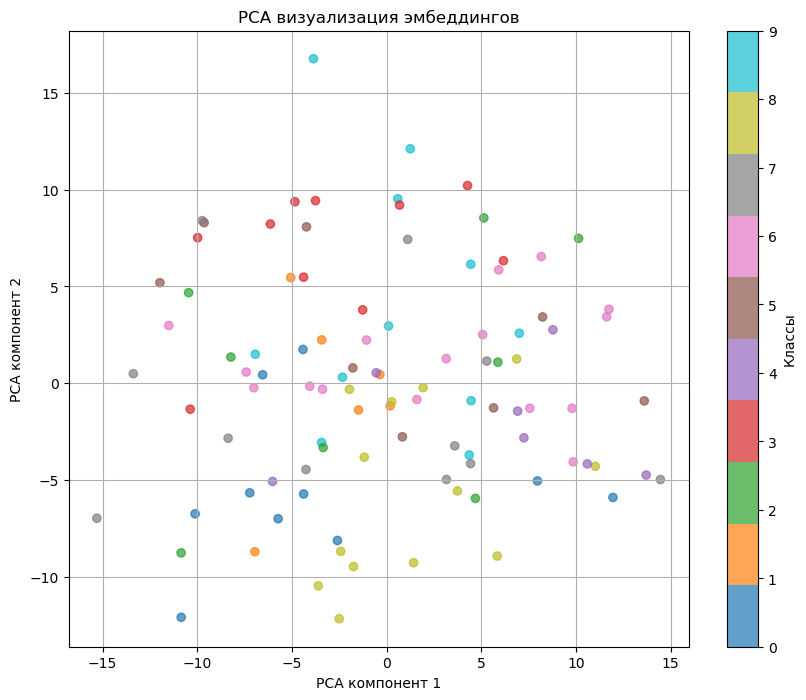

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

embeddings_np = embeddings.numpy()
classes_np = classes.numpy()

# Применяем PCA для снижения размерности до 2
pca = PCA(n_components=2)
pca_result_1 = pca.fit_transform(embeddings_np)

# Визуализация scatter plot с цветами по классам
plt.figure(figsize=(10, 8))

# Создаём цветовую карту для классов
num_classes = len(np.unique(classes_np))
colors = plt.cm.get_cmap('tab10', num_classes)

scatter = plt.scatter(pca_result_1[:, 0], pca_result_1[:, 1], c=classes_np, cmap=colors, alpha=0.7)

plt.colorbar(scatter, ticks=range(num_classes), label='Классы')
plt.title('PCA визуализация эмбеддингов')
plt.xlabel('PCA компонент 1')
plt.ylabel('PCA компонент 2')
plt.grid(True)
plt.show()


# 3. Обучение автоэнкодера
В данной реализации приведен не очень хороший, но рабочий автоэнкодер. Его уже придется обучить на тренировочном датасете


## __latent_dim = 2__

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Устройство для обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Автоэнкодер
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Autoencoder, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 32x16x16
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 64x8x8
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 128x4x4
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        # Линейные слои для латентного пространства
        self.fc1 = nn.Linear(128*4*4, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 128*4*4)

        # Декодер
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 64x8x8
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # 32x16x16
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),    # 3x32x32
            nn.Sigmoid(), 
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        z = self.fc1(x)
        return z

    def decode(self, z):
        x = self.fc2(z)
        x = x.view(x.size(0), 128, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z)
        return out

# Загрузка CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

latent_dim = 2
model_1 = Autoencoder(latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_1.parameters(), lr=1e-3)


In [6]:

# Обучение автоэнкодера
num_epochs = 20
for epoch in range(num_epochs):
    model_1.train()
    running_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model_1(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")


Epoch [1/20], Loss: 0.038756
Epoch [2/20], Loss: 0.037058
Epoch [3/20], Loss: 0.036886
Epoch [4/20], Loss: 0.036729
Epoch [5/20], Loss: 0.036600
Epoch [6/20], Loss: 0.036484
Epoch [7/20], Loss: 0.036383
Epoch [8/20], Loss: 0.036322
Epoch [9/20], Loss: 0.036259
Epoch [10/20], Loss: 0.036217
Epoch [11/20], Loss: 0.036171
Epoch [12/20], Loss: 0.036084
Epoch [13/20], Loss: 0.036033
Epoch [14/20], Loss: 0.036004
Epoch [15/20], Loss: 0.035940
Epoch [16/20], Loss: 0.035860
Epoch [17/20], Loss: 0.035830
Epoch [18/20], Loss: 0.035800
Epoch [19/20], Loss: 0.035770
Epoch [20/20], Loss: 0.035699


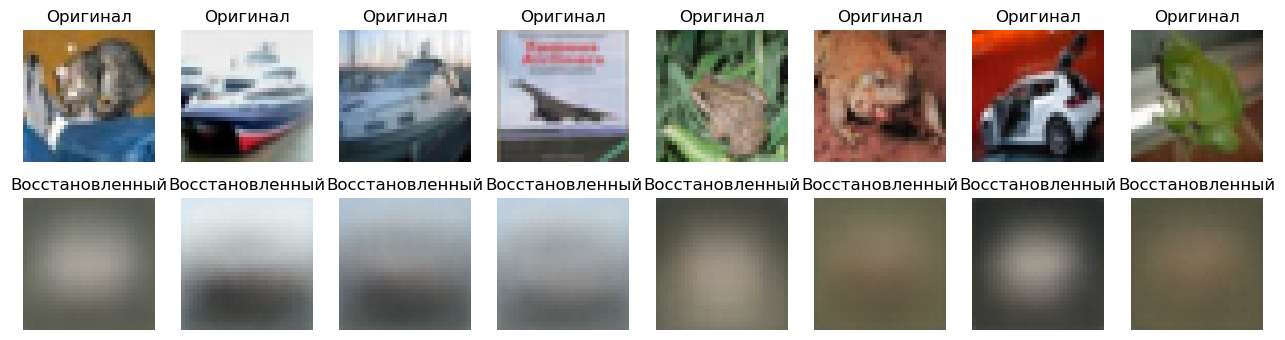

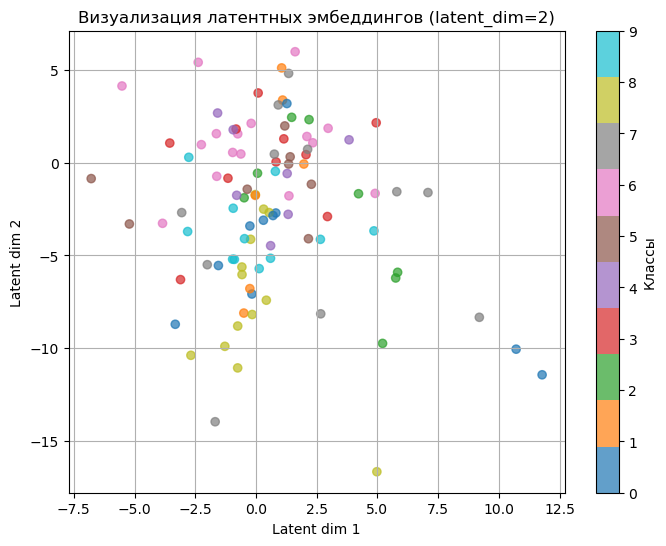

In [7]:
model_1.eval()
embeddings_1 = []
classes_1 = []

n = 8  # количество изображений для отображения
max_steps = 10
plt.figure(figsize=(16, 4))

with torch.no_grad():
    dataiter = iter(test_loader)
    count = 0
    while count < n:
        images, labels = next(dataiter)
        images = images.to(device)
        outputs = model_1(images)
        emb = model_1.encode(images)
        embeddings_1.append(emb.cpu())
        classes_1.append(labels)

        images = images.cpu()
        outputs = outputs.cpu()

        batch_size = images.size(0)
        for i in range(batch_size):
            if count >= n:
                break
            # Исходное изображение
            ax = plt.subplot(2, n, count + 1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title("Оригинал")
            plt.axis('off')

            # Восстановленное изображение
            ax = plt.subplot(2, n, count + 1 + n)
            plt.imshow(outputs[i].permute(1, 2, 0))
            plt.title("Восстановленный")
            plt.axis('off')

            count += 1

plt.show()

# Объединяем эмбеддинги и классы
embeddings_tensor = torch.cat(embeddings_1)
classes_tensor = torch.cat(classes_1)

embeddings_np = embeddings_tensor.numpy()
classes_np = classes_tensor.numpy()

import matplotlib.pyplot as plt

# embeddings_np — numpy-массив размерности [N, 2]
# classes_np — метки классов

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1], c=classes_np, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Классы')
plt.title('Визуализация латентных эмбеддингов (latent_dim=2)')
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.grid(True)
plt.show()




## двумерный вектор эмбединга работает плохо

In [8]:
latent_dim

2

## __latent_dim = 64__  
## Сделаем эмбеддинг больше 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

# Загрузка CIFAR-10 
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

latent_dim = 64
model_2 = Autoencoder(latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [10]:

# Обучение автоэнкодера
num_epochs = 30
for epoch in range(num_epochs):
    model_2.train()
    running_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model_2(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")
    scheduler.step()


Epoch [1/30], Loss: 0.018335
Epoch [2/30], Loss: 0.009844
Epoch [3/30], Loss: 0.008735
Epoch [4/30], Loss: 0.008461
Epoch [5/30], Loss: 0.008305
Epoch [6/30], Loss: 0.008069
Epoch [7/30], Loss: 0.008023
Epoch [8/30], Loss: 0.008007
Epoch [9/30], Loss: 0.007950
Epoch [10/30], Loss: 0.007919
Epoch [11/30], Loss: 0.007794
Epoch [12/30], Loss: 0.007791
Epoch [13/30], Loss: 0.007773
Epoch [14/30], Loss: 0.007748
Epoch [15/30], Loss: 0.007734
Epoch [16/30], Loss: 0.007670
Epoch [17/30], Loss: 0.007673
Epoch [18/30], Loss: 0.007663
Epoch [19/30], Loss: 0.007636
Epoch [20/30], Loss: 0.007617
Epoch [21/30], Loss: 0.007596
Epoch [22/30], Loss: 0.007588
Epoch [23/30], Loss: 0.007587
Epoch [24/30], Loss: 0.007576
Epoch [25/30], Loss: 0.007580
Epoch [26/30], Loss: 0.007554
Epoch [27/30], Loss: 0.007548
Epoch [28/30], Loss: 0.007552
Epoch [29/30], Loss: 0.007549
Epoch [30/30], Loss: 0.007539


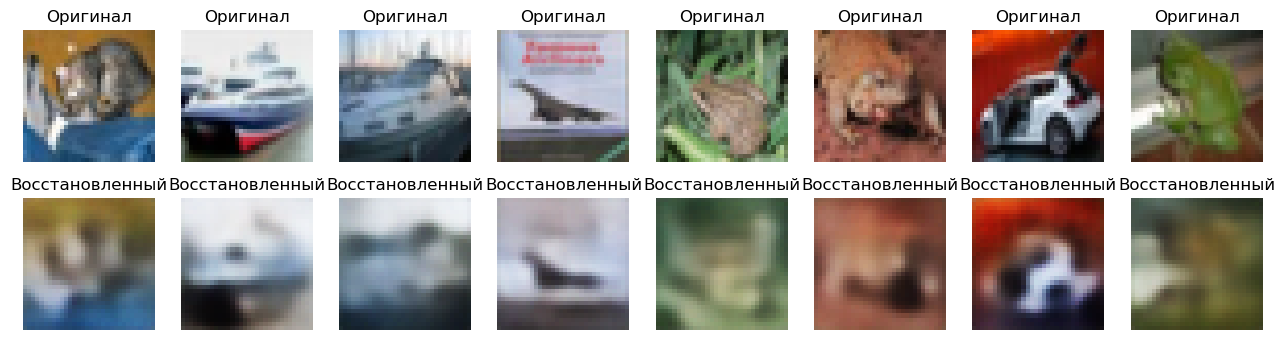

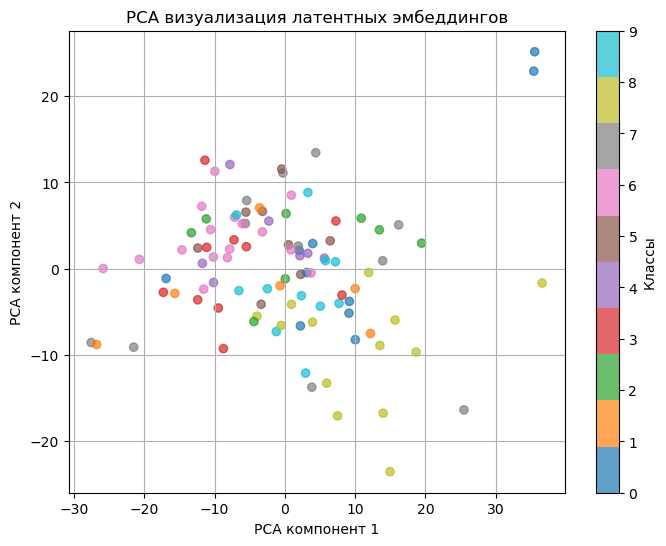

In [11]:
model_2.eval()
embeddings_2 = []
classes_2 = []

n = 8  # количество изображений для отображения
max_steps = 10
plt.figure(figsize=(16, 4))

with torch.no_grad():
    dataiter = iter(test_loader)
    count = 0
    while count < n:
        images, labels = next(dataiter)
        images = images.to(device)
        outputs = model_2(images)
        emb = model_2.encode(images)
        embeddings_2.append(emb.cpu())
        classes_2.append(labels)

        images = images.cpu()
        outputs = outputs.cpu()

        batch_size = images.size(0)
        for i in range(batch_size):
            if count >= n:
                break
            # Исходное изображение
            ax = plt.subplot(2, n, count + 1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title("Оригинал")
            plt.axis('off')

            # Восстановленное изображение
            ax = plt.subplot(2, n, count + 1 + n)
            plt.imshow(outputs[i].permute(1, 2, 0))
            plt.title("Восстановленный")
            plt.axis('off')

            count += 1

plt.show()



# Объединяем эмбеддинги и классы
embeddings_tensor = torch.cat(embeddings_2)
classes_tensor = torch.cat(classes_2)

embeddings_np = embeddings_tensor.numpy()
classes_np = classes_tensor.numpy()

# Визуализация с PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=classes_np, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Классы')
plt.title('PCA визуализация латентных эмбеддингов')
plt.xlabel('PCA компонент 1')
plt.ylabel('PCA компонент 2')
plt.grid(True)
plt.show()




## Размерность эмбеддинга 2 слишком низкая для  представления  
## сложных и многомерных данных